In [6]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from IPython.display import Image

# Chapter 20 深層生成モデル~Deep Generative Models~
---
#### 概要
- 本章では、生成モデルの中でも特にRestricted Boltzmann MachineとDeep Boltzmann Machine を中心に説明している
- その他では、生成モデルに関連した話題が述べられている
- 13,18,19章を参考にすることが多々ある

今日の発表について) 
- 分量が多いので後で読み返せるようにまとめました。発表では、要点だけを述べます。
- TODOが多く、節として簡潔していない20.6~20.9は割愛します。
- 適宜内容を改善していく予定です。Deep Learning界の用語や慣習にはまだ慣れていないので、説明などに違和感があれば教えてください。

## 20.1 ボルツマンマシン (Boltzmann Machine)
---

#### 導入
- 歴史的には、Ackley et al.(1985)から導入され始めた
- その中でもRBMはPre-trainig の方法としてAutoencoderと双璧をなす

### 基礎事項 (+統計力学の復習)
ボルツマンマシンはエネルギーモデルなので、その記述に必要な状態、エネルギー、確率分布を定義する(Sec. 13.2の復習)。

**ボルツマンマシンの状態**
$d$個のユニットからなるボルツマンマシンの状態は各元がランダムな二値変数である$d$-次元ベクトル$\bf{x}\in\{0,1\}^d$で定義される。なお、可視層と隠れ層を分けて考える場合は、$\bf{x}=(\bf{x_v},\bf{x_h})^T$と書かれる。

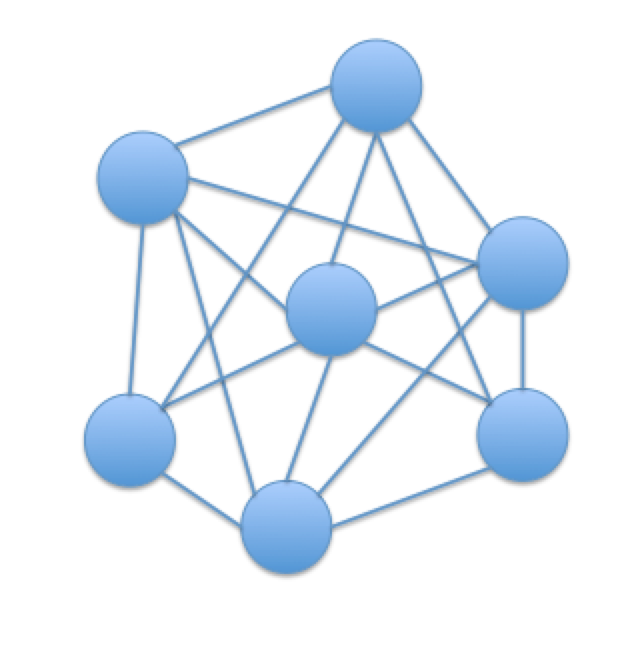

In [3]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "BM.png", width=300, height=300)

1.**エネルギー関数**

######一般のボルツマンマシン
各ユニット間の重みを$d\times{d}$行列$\bf$、バイアスを$d$次元ベクトル$\bf{b}$とすると、エネルギー関数は以下のように書かれる。

$$ E(\bf{x}) = -\bf{x}^T\bf{U}\bf{x}-\bf{b}^T\bf{x}\tag{20.1.1} $$

######可視層と隠れ層に分けた場合のボルツマンマシン
可視層間の重みを$\bf{R}$、可視層と隠れ層を結ぶ重みを$\bf{W}$、隠れ層間の重みを$\bf{S}$、可視層のバイアスを$\bf{b}$、隠れ層のバイアスを$\bf{c}$とすると、エネルギー関数は、

$$ E(\bf{x}_v,\bf{x}_h) = -\bf{x}_v^T\bf{R}\bf{x}_v-\bf{x}_v^T\bf{W}\bf{x}_h-\bf{x}_h^T\bf{S}\bf{x}_h-\bf{b}^T\bf{x}_v-\bf{c}^T\bf{x}_h\tag{20.1.2} $$



補足)
一般に、ボルツマンマシンに課される制約は、
1. $u_{ii}=0$ (自分自身とは繋がらない)
2. $u_{ij}=u_{ji}$ (全ての繋がりは対称的)



2.**分配関数**:

分配関数はボルツマンマシンが取りうる全ての状態$\bf{x}\in\{0,1\}^d$についてボルツマン因子$\exp(-E(\bf{x}))$の和をとったものであり、以下のように書かれる。

$$Z=\sum_{\bf{x}}^{2^d}\rm{exp}(-E(\bf{x}))\tag{20.1.3}$$

3.**確率分布**:

ボルツマンマシンが状態$\bf{x}$にある確率は、以下のように書かれる。

$$ P(\bf{x})=\frac{1}{Z}exp(-E(\bf{x}))\tag{20.1.4} $$

以後、どのモデルについてもこの1.$\approx$3.を基礎に議論が進む


### ベンジオさんの主張　~隠れ層の意義について~ 
- 式20.1.1で書かれるような、可視層と隠れ層の区別がない一般的なボルツマンマシンは、高々一次の相互作用までしか取り込めない($-\bf{x}^TU\bf{x}$の部分)。

 
 

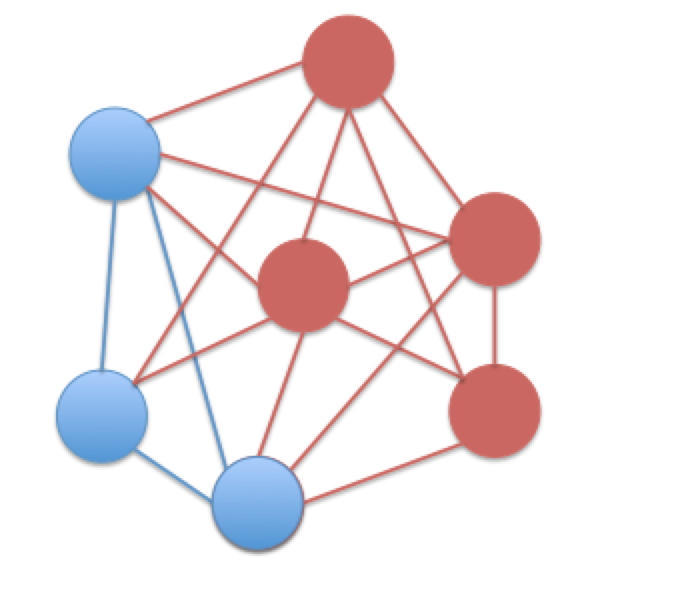

In [4]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "BM2.png", width=300, height=300)

- **隠れ層の導入$\rightarrow$高次の相互作用の取り込み**
 - 隠れ層は無駄になるが、可視層だけに注目すれば、高次の相互作用を含んだモデルになる(正確に言えば、一次の相互作用だけでは説明できないモデルになる)。
 - 恐らく、$-\bf{x}_v^T\bf{W}\bf{x}_h-\bf{x}_h^T\bf{S}\bf{x}_h$による影響のことを言っているのだろう。
 
- **よって、この章では可視層と隠れ層を区別したボルツマンマシンを前提に説明を進める。**


######所感
- 直感的には理解できるが、数学的な証明は...?
- 高次の相互作用を取り込んだニューラルネットワークの効用についてはこの[論文](http://clgiles.ist.psu.edu/AO-1987-nn_invariance.pdf)が参考になるかもしれません。


### ボルツマンマシン学習 (Boltzmann Machine learning)

- 最尤法を用いる。
- 以下の、独立同分布な$n$個のデータセットを用いることを考える。

$$ \bf{X} = [\bf{x}_v^{(1)},...,\bf{x}_v^{(t)},...,\bf{x}_v^{(n)}]$$



- 目的は、このデータセットを高確率で生成するボルツマンマシンを構成すること。そのために、各$\bf{x}_v^{(n)}$が生成される確率が高くなるようにしたい。
- よって、以下の対数尤度$l(\theta)$を最大化するように学習させる。

$$ l(\theta)=\rm{log}P(\bf{X}_v)=\sum_{t=1}^n\rm{log}P(\bf{x}_v^{(t)})\tag{20.1.5}$$



- ただし、この章で扱うのは一般のボルツマンマシンではなく、**可視層と隠れ層を区別したボルツマンマシンであるから**、それを明示的に書くと、以下のようになる。

$$ P(\bf{x}_v^{(t)})=\sum_{\bf{x}_h}P(\bf{x}_v^{(t)},\bf{x}_h^{(t)})=\sum_{\bf{x}_h}\frac{1}{Z}\{-E(\bf{x}_v^{(t)},\bf{x}_h^{(t)})\}\tag{20.1.6} $$



- これは、解析的には求まらないことが分かっているので、勾配法を用いる。

$$ \frac{\partial}{\partial\bf{\theta}}l(\bf{\theta})=\sum_{t=1}^{n}\Biggl[\sum_{\bf{x}_h}\frac{\rm{exp}\{-E(\bf{x}_v^{(t)},\bf{x}_h^{(t)})\}}{\sum_{\bf{x}_h}\rm{exp}\{-E(\bf{x}_v^{(t)},\bf{x}_h^{(t)})\}}\frac{\partial}{\partial\bf{\theta}}E(\bf{x}_v^{(t)},\bf{x}_h^{(t)})\Biggr]-\frac{\partial{Z}}{\partial\bf{\theta}}\tag{20.1.7}$$



- 本節以降は、いかにこの勾配を効率的に求めるかが重要になってくる。当然、一般のボルツマンマシンでは非効率なので、次節で制約付きボルツマンマシン(Restricted Boltzmann Machine)を導入する。

## 20.2 制約付きボルツマンマシン (Restricted Boltzmann Machines)　
---
- RBMは深層的な確率モデルにとって最も一般的な構成要素である。


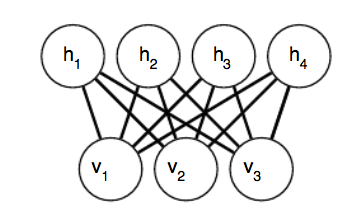

In [3]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "RBM.png", width=500, height=500)

- 特徴
 1. 確率的な無向グラフ
 2. 二層から成っており、一つの層は可視層、もう片方は隠れ層というように分かれている
 3. 同じ層内のユニット同士は結合させない $\rightarrow$ 層内の各ユニットの条件付き確率が独立になる $\rightarrow$ 計算が楽になる
 4. 同じ構造を何層も積み重ねることができる $\rightarrow$ Deep Boltzmann Machineへ
 



- 表記法($D$個の可視層と$N$個の隠れ層からなるRBMの場合)
 - 可視層は$D$次元の二値ランダム変数$\bf{v}$で表され、可視層内の$i$番目のユニットは$v_i$で表される。
 - 隠れ層は$N$次元の二値ランダム変数$\bf{h}$で表され、可視層内の$j$番目のユニットは$h_j$で表される。
 

確率分布について

1. **エネルギー関数**:  同じ層内のユニット同士は結合しない(特徴3)ので、$\bf{R}$と$\bf{S}$は消え、

$$ E(\bf{v},\bf{h})=\bf{b}^T\bf{v}-\bf{c}^T\bf{h}-\bf{v}^T\bf{W}\bf{h}\tag{20.2.1} $$
 
2. **分配関数**: 
 
$$ Z=\sum_{\bf{v}}\sum_{\bf{h}}\rm{exp}\{-E(\bf{v},\bf{h})\}\tag{20.2.2} $$
 
3. **確率分布**
 
$$ P(\bf{\rm{v}}=\bf{v},\bf{\rm{h}}=\bf{h})=\frac{1}{Z}\rm{exp}\{-E(\bf{v},\bf{h})\}\tag{20.2.3} $$

###  20.2.1 条件付き分布 (Conditional Distributions)

- 一般のボルツマンマシンは、分配関数$Z$が計算困難であり、同様に同時確率$p(\bf{v},\bf{h})$も求めづらい。
- しかし、RBMでは、条件付き分布$P(\bf{h}|\bf{v})$と$P(\bf{v}|\bf{h})$が連乗積で書け、計算的に比較的負担が少なく求められる。

$$ P(\bf{h}|\bf{v})= \prod_{j=1}^nP(h_j|\bf{v}) =\prod_{j=1}^n\rm{sigmoid}(c_j+\bf{v}^T\bf{W}_{:,j})\tag{20.2.4} $$
$$ P(\bf{v}|\bf{h})= \prod_{i=1}^dP(v_i|\bf{h}) =\prod_{i=1}^d\rm{sigmoid}(b_i+\bf{W}_{i,:}\bf{h})\tag{20.2.5}   $$
この式の導出は本編を参考にして頂きたいが、大事なのは、


1. 条件付き分布がsigmoid関数の**連乗積**で書けること
2. この変形は**同じ層内のユニット間では結合を許さない**といったRBM特有の制約に依拠すること
3. この特徴こそ、RBMが普及した要因であること

### 20.2.2 ギブスサンプリング (RBM Gibbs Sampling)
20.2.1節で得られた条件付き確率は、$\bf{v}$と$\bf{h}$の同時確率分布$P(\bf{v},\bf{h};\theta)$を求めるときに利用される。同時確率と条件付き確率の関係から、

$$ \bf{P}(\bf{v},\bf{h};\theta)=P(\bf{v})P(\bf{h}|\bf{v};\theta) $$

であるが、学習の過程では、条件付き確率$P(\bf{h}|\bf{v};\theta)$はその時点でのボルツマンマシンのパラメータ$\theta$($\bf{W}$、$\bf{b}$、$\bf{c}$など)によって決まるが、$P(\bf{v})$は自分で与えなくてはいけなく$\theta$に依存しているとは限らない。そこで、$\bf{P}(\bf{v};\theta)\approx P(\bf{v})$となるように、ギブスサンプリングを行う。ギブスサンプリングの各ステップを、$l=0,1,...,l...L$とすると、$l$番目の$\bf{v}^{(l)}$が与えられたとき$\bf{h}$と$\bf{v}^{(l+1)}$は以下のように決まる。ただし、$\bf{v}^{(0)}$には訓練データを用いるとする。



####step1.
$\bf{h}^{(l)}$を$\bf{P}(\bf{h}|\bf{v}^{(l)})P(\bf{v}^{(l)})$からサンプルし、その確率分布を$\bf{P}(\bf{h}^{(l)})$とする。
####step2.
$\bf{v}^{(l+1)}$を$\bf{P}(\bf{v}|\bf{h}^{(l)})P(\bf{h}^{(l)})$からサンプルし、その確率分布を$\bf{P}(\bf{v}^{(l+1)})$とする。

## 20.3 制約付きボルツマンマシンの学習 (Training Restricted Boltzmann Machines)
---

- 訓練データを高確率で生成するボルツマンマシンになるように学習させるためには、最尤法を用いる。
- やっていることは20.1節の繰り返しで、式20.1.7に式20.2.1を代入しているだけ。
- この節で注目すべきことは、今回はパラメータに制約がつくことで、計算量的にも負担がないようなモデルになっていること。

$$ \nabla_{\bf{\theta}}l(\bf{\theta})=\sum_{t=1}^n  \Big\langle \nabla_{\bf{\theta}}[-E(\bf{v}^{(t)},\bf{h})]\Big\rangle_{\bf{P}(\bf{h}|\bf{v}^{(t)})} -n\Big\langle \nabla_{\bf{\theta}}[-E(\bf{v},\bf{h})]\Big\rangle_{\bf{P}(\bf{v},\bf{h})}\tag{20.3.1} $$



- 第1項の期待値は"データ項"と呼ばれ、訓練データによって得られる経験確率 $\bf{P(v)}=\frac{1}{n}\sum_{t=1}^n\delta(x-\bf{v}^{(t)})$と条件付き確率 $\bf{P}(\bf{h}|\bf{v})$の積によって決まる $\rightarrow$ 計算が容易。
- 第2項の期待値は"モデル項"と呼ばれ、モデルの同時確率$\bf{P}(\bf{v},\bf{h})$によって決まる $\rightarrow$ 本来であれば計算が困難 $\rightarrow$ CD法などによって克服

また、
$$ \nabla_{\bf{W}}[-E(\bf{v},\bf{h})] = \frac{\partial}{\partial{\bf{W}}}(\bf{b}^T\bf{v}+\bf{c}^T\bf{h}+\bf{v}^T\bf{W}\bf{h}) = \bf{h}\bf{v}^T\tag{20.3.2} $$

$$ \nabla_{\bf{b}}[-E(\bf{v},\bf{h})] = \bf{v}\tag{20.3.3} $$

$$ \nabla_{\bf{c}}[-E(\bf{v},\bf{h})] = \bf{h}\tag{20.3.4} $$
より、対数尤度は以下のように変形される。

$$ \nabla_{\bf{W}}l(\bf{W},\bf{b},\bf{c}) = \sum_{t=1}^n\hat{\bf{h}}^{(t)}{\bf{b}^{(t)}}^T - N\Big\langle\bf{h}\bf{v}^T\Big\rangle_{\bf{P}(\bf{v},\bf{h})}\tag{20.3.5} $$

$$ \nabla_{\bf{b}}l(\bf{W},\bf{b},\bf{c}) = \sum_{t=1}^n\bf{b}^{(t)} - N\Big\langle\bf{v}\Big\rangle_{\bf{P}(\bf{v},\bf{h})}\tag{20.3.6} $$

$$ \nabla_{\bf{c}}l(\bf{W},\bf{b},\bf{c}) = \sum_{t=1}^n\hat{\bf{h}}^{(t)} - N\Big\langle\bf{h}\Big\rangle_{\bf{P}(\bf{v},\bf{h})}\tag{20.3.7} $$

ただし、ここでは$\hat{h}^{(t)}$を以下のように定義した。

$$ \hat{h}^{(t)}=\Big\langle\bf{h}\Big\rangle_{\bf{P}(\bf{h}|\bf{b}^{(t)})}=\rm{sigmoid}(\bf{c}+\bf{v}^{(t)}\bf{W})\tag{20.3.8} $$



これまでの議論とと同様に、$\bf{P}(\bf{v}|\bf{h})$と$\bf{P}(\bf{h}|\bf{v})$の期待値は求め易い一方、$\bf{P}(\bf{v},\bf{h})$の期待値は解析的には求まらない。そこで、$\bf{P}(\bf{v},\bf{h})$の期待値はCD法(Contrastive Divergence Method)やStochastic Maximum Likelihood法を用いて近似的に求める。

### 20.3.1 対照収束法 (CD法、Contrastive Divergence Training of the RBM)

####step1. 
ギブスサンプリングによって近似的に$\bf{P}(\bf{v})_T\approx \bf{P}(\tilde{\bf{v}};\theta)$を生成する。Tはギブスサンプリングを行ったステップ数である。

####step2.
ギブスサンプリングによって生成された$\bf{P}(\tilde{\bf{v}})$を用いて、$\bar{h}^{(t)}=\rm{sigmoid}(\bf{c}+{\bf{v}^{(t)}}^T\bf{W})$を得る。

####step3.
(20.3.5)$\sim$(20.3.7)の更新式に従って、パラメータを調整する。

####step4.
収束するまでstep1.からstep3.を繰り返す。ただし、次の更新におけるギブスサンプリングの$\tilde{\bf{v}}_0$は**訓練データ**から得られるものする。

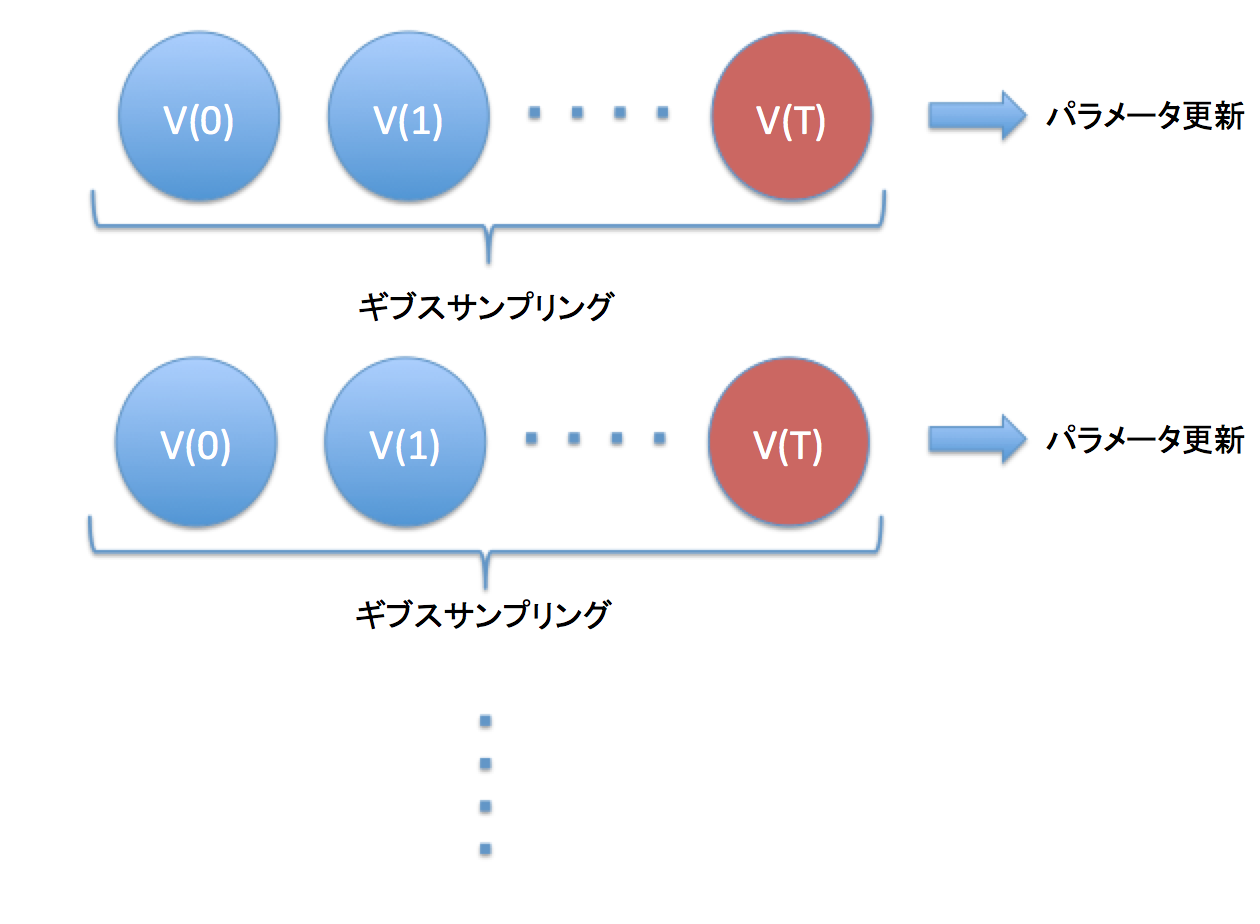

In [20]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "CD.png", width=500, height=500)

### 20.3.2 制約付きボルツマンマシンのための確率的最尤法 (Stochastic Maximum Likelihood (Persistent Contrastive Divergence) for the RBM)
CD法とほとんど変わらないが、step4.のところの$\tilde{\bf{v}}_0$の初期値の設定の仕方が変わってくる。
####step1. 
ギブスサンプリングによって近似的に$\bf{P}(\bf{v})_T\approx \bf{P}(\tilde{\bf{v}};\theta)$を生成する。Tはギブスサンプリングを行ったステップ数である。

####step2.
ギブスサンプリングによって生成された$\bf{P}(\tilde{\bf{v}})$を用いて、$\bar{h}^{(t)}=\rm{sigmoid}(\bf{c}+{\bf{v}^{(t)}}^T\bf{W})$を得る。

####step3.
(20.3.5)$\sim$(20.3.7)の更新式に従って、パラメータを調整する。

####step4.
収束するまでstep1.からstep3.を繰り返す。ただし、次の更新におけるギブスサンプリングの$\tilde{\bf{v}}_0$は**前回の更新時の終状態$\tilde{\bf{v}}_T$**から得られるものする。

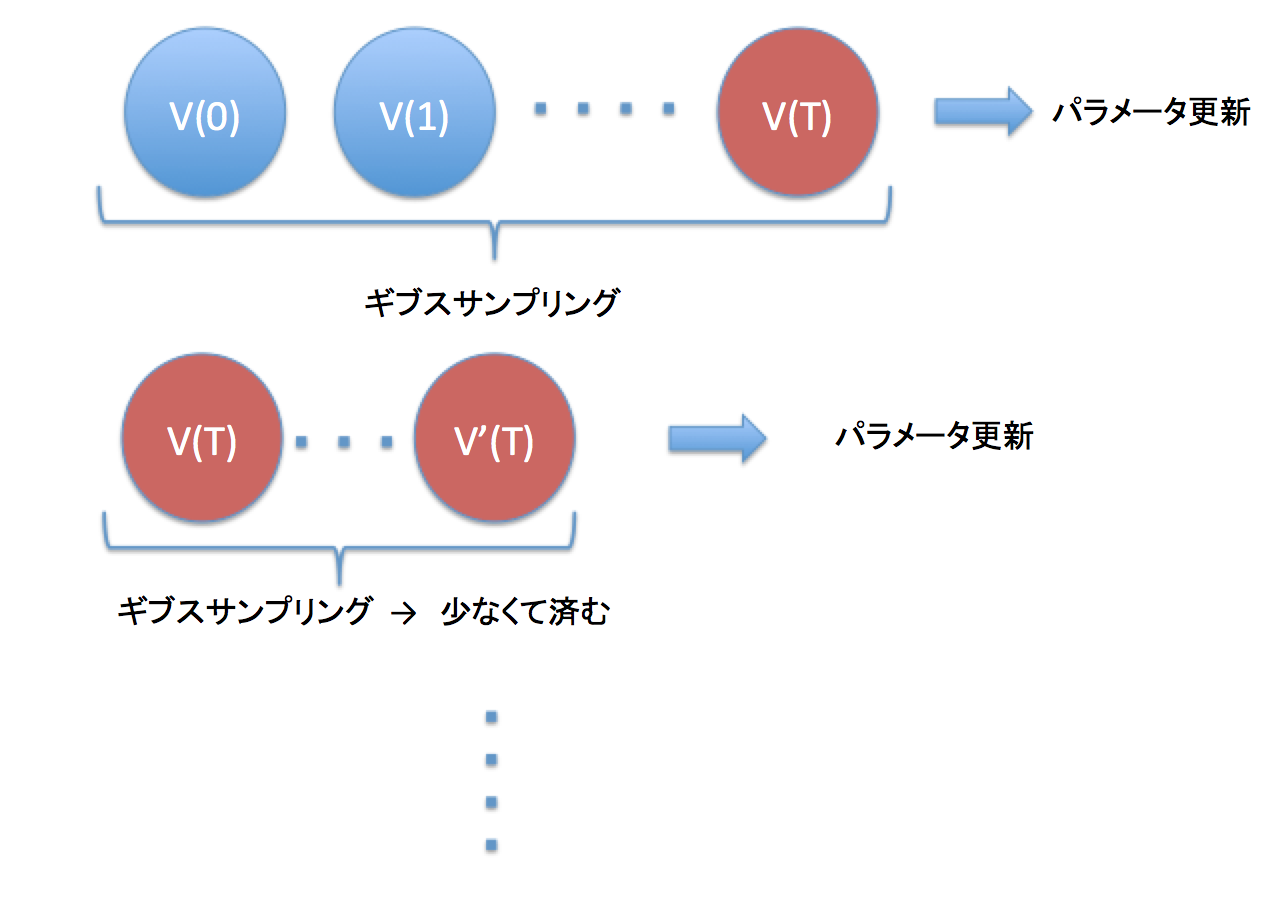

In [21]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "SML.png", width=500, height=500)

## 20.4 深層ネットワーク (Deep Belief Network, 以下DBN) 
---

- 2006年のHintonによるDBNの導入がDeep Learningブームの火付け役となった。
- 現在ではほとんど使われていない。

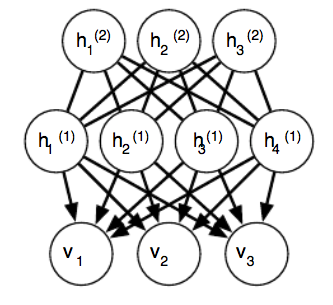

In [5]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "DBN.png", width=500, height=500)

- 特徴
 1. 多層の隠れ層を持つ
 2. 大抵の場合、隠れ層は2値で、可視層は2値または実数値である
 3. ボルツマンマシンと同様、層内結合はない
 4. 隠れ層の最上位二層は無向グラフで、それ以下は全て可視層の方に向かった有向グラフ


- 同時確率$\bf{P}(\bf{v},\bf{h}^{(1)},...,\bf{h}^{(L)})$を得る手順
 1. 最上位二層についてギブスサンプリングを行う
 2. それ以下の有向グラフに関しては伝承サンプリング(ancestral sampling)を行う


- DBNの欠点
 無向グラフにおける計算困難性と有向グラフにおける計算困難性を両方含むこと
 

## 20.5 深層ボルツマンマシン (Deep Boltzmann Machine, 以下DBM) 
---

- DBMはRBMを多層に積み上げたものである
- 特徴
 1. 完全な無向グラフ
 2. 同じ層内のユニット同士は結合させない $\rightarrow$ 層内の各ユニットの条件付き確率が独立になる $\rightarrow$ 計算が楽になる
 
 


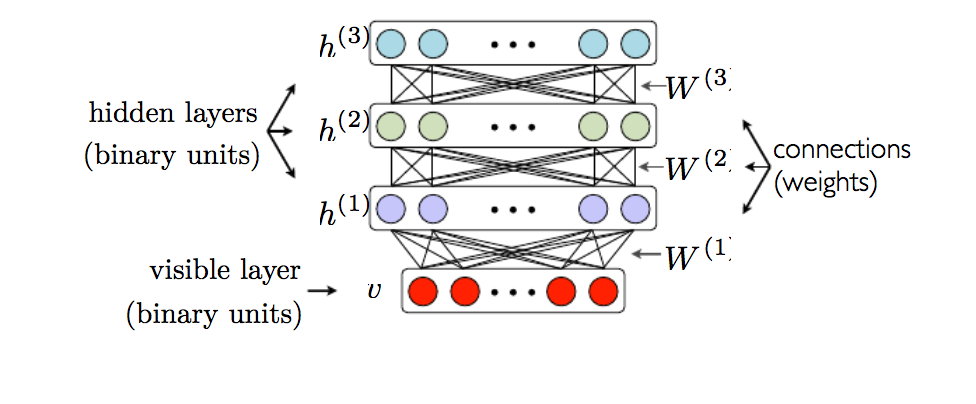

In [7]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "DBM.png", width=700, height=700)

- 表記法(3層のDBMからなるRBMの場合)
 - 可視層は二値ランダム変数$\bf{v}$で表され、可視層内の$i$番目のユニットは$v_i$で表される。
 - 隠れ層は二値ランダム変数$\bf{h}^{(1)}$、$\bf{h}^{(2)}$、$\bf{h}^{(3)}$で表され、可視層内の$j$番目のユニットは$h_j^{(1)}$、$h_j^{(2)}$、$h_j^{(2)}$で表される。
 

- 確率分布について

 1. **エネルギー関数**:  
 $$ E(\bf{v},\bf{h}^{(1)},\bf{h}^{(2)},\bf{h}^{(3)};\bf{\theta})=-\bf{v}^T\bf{W}^{(1)}\bf{h}^{(1)}-{\bf{h}^{(1)}}^T\bf{W}^{(2)}\bf{h}^{(2)}-{\bf{h}^{(2)}}^T\bf{W}^{(3)}\bf{h}^{(3)}\tag{20.5.1} $$
 2. **分配関数**: 
 $$ Z(\bf{\theta})=\sum_{\bf{v}}\sum_{\bf{h}^{(1)}}\sum_{\bf{h}^{(2)}}\sum_{\bf{h}^{(3)}}\rm{exp}\{-E(\bf{v},\bf{h}^{(1)},\bf{h}^{(2)},\bf{h}^{(3)};\bf{\theta})\tag{20.5.2} $$
 3. **確率分布**
 $$ P(\bf{\rm{v}}=\bf{v},\bf{\rm{h}}=\bf{h})=\frac{1}{Z(\bf{\theta})}\rm{exp}\{-E(\bf{v},\bf{h}^{(1)},\bf{h}^{(2)},\bf{h}^{(3)};\bf{\theta})\}\tag{20.5.3} $$
 
 


- 条件付き確率の独立性について
多層構造のどの二つの層をとっても、二部グラフになっており、特徴2.と合わせることで、層内の各ユニットの条件付き確率が独立になる。

$$ \bf{P}(\bf{h}^{(1)}|\bf{v},\bf{h}^{(2)}) = \frac{\bf{P}(\bf{h}^{(1)},\bf{v},\bf{h}^{(2)})}{\bf{P}(\bf{v},\bf{h}^{(2)})} = \prod_j\bf{P}(h_j^{(1)}\big|\bf{v},\bf{h}^{(2)})\tag{20.5.4} $$ 

イメージ) $\bf{v}$と$\bf{h}^{(2)}$を一つとみなして、$\bf{h}^{(1)}$の条件付き確率を求める (20.2.1と同じ操作をする)。



同様にして、他の層間でも条件付き確率が連乗積で表せる。

$$ \bf{P}(\bf{v}|\bf{h}^{(1)}) = \prod_{i=1}^d\bf{P}(v_i|\bf{h}^{(1)})\tag{20.5.5} $$
$$ \bf{P}(\bf{h}^{(2)}|\bf{h}^{(1)}) = \prod_{k=1}^m\bf{P}(h^{(2)}_k|\bf{h}^{(1)})\tag{20.5.6} $$

### 20.5.2 DBMにおける平均場推定 (DBM Mean Field Inference)

- ***この節の内容はRBMにおけるギブスサンプリングに対応する***


$ \bf{P}(\bf{h}^{(1)}|\bf{v},\bf{h}^{(2)}) $、$\bf{P}(\bf{v}|\bf{h}^{(1)})$、$\bf{P}(\bf{h}^{(2)}|\bf{h}^{(1)})$は解析的に求まったが、同時確率分布$\bf{P}(\bf{h}^{(1)},\bf{h}^{(2)},\bf{v})$を求めるのに必要な$\bf{P}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})$は解析的に求まらず、計算的にも負担が大きい。なぜなら、重み$\bf{W}^{(2)}$があるため、$\bf{P}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})$が連乗積で表せないからだ。 $\bf{h}^{(1)}$と$\bf{h}^{(2)}$を一つの層とみなすと、層内結合が含まれることになるからである。

そこで、$\bf{P}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})$を近似的に求める必要がでてくるのだが、DBMではvariational approximationが度々用いられる。その中でも、この節では**完全な連乗積で表せる分布**で近似する平均場近似を用いる。すなわち、隠れ層内の各ユニットが互いに独立になるようなモデルで近似を行う。

$\bf{P}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})$を近似する確率分布を$\bf{Q}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})$とすると、平均場近似では、**完全な連乗積で表される分布**に近似するので、

$$ \bf{Q}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})=\prod_{j=1}^n\bf{Q}(h_j^{(1)}|\bf{v})\prod_{k=1}^m\bf{Q}(h_k^{(2)}|\bf{v})\tag{20.5.7} $$

と表される。

次に、$\bf{Q}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})$がどれだけ$\bf{P}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})$に近いかを定量化するために、以下のKullback-Leibler Divergenceを定義する。

$$ KL(\bf{Q}||\bf{P})=\sum_{\bf{h}}\bf{Q}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})\rm{log}\frac{\bf{Q}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})}{\bf{P}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})}\tag{20.5.8} $$


また、これまで$\bf{Q}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})$の関数の形は特に定めていなかったが、ベルヌーイ分布に従っていると仮定しても一般性は崩れないので(?)、各$j\in\{1,...,n\}$について$\hat{h}_j^{(1)}=P(h_j^{(1)}=1)\in[0,1]$とすると、

$$ \bf{Q}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})=\prod_{j=1}^n(\hat{h}_j^{(1)})^{h_j^{(1)}}(1-\hat{h}_j^{(1)})^{(1-h^{(1)})}
\prod_{k=1}^m(\hat{h}_j^{(2)})^{h_j^{(2)}}(1-\hat{h}_j^{(2)})^{(1-h^{(2)})}\tag{20.5.9} $$

目的は、Kullback-Leibler Divergenceの最小化であるが、これはELBO (Evidence Lower BOund)を最大化することと等価である([参照](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf))。よって、以下のELBOを最大化することを次の目標とする。

$$ L(\bf{Q}) = - \sum_{\bf{h}^{(1)},\bf{h}^{(2)}} \bf{Q}(\bf{h}^{(1)},\bf{h}^{(2)}|\bf{v})E(\bf{v},\bf{h}^{(1)},\bf{h}^{(2)};\bf{\theta})-\rm{log}Z(\bf{\theta})+H(\bf{Q})\tag{20.5.10} $$

式(20.5.9)を代入すると、

$$ L(\bf{q}) = - \sum_i\sum_{j'}v_iW_{i,j'}^{(1)}\hat{h}_{j'}^{(1)} + \sum_{j'}\sum_{k'}\hat{h}_{j'}^{(1)}W_{j',k'}^{(2)}\hat{h}_{k'}^{(2)} - \rm{log}Z(\theta) + \bf{H}(q)\tag{20.5.11}$$

これを最大化するために、各パラメータ$i\in\{1,...,n\}, k\in\{1,...,m\}$について偏微分する。

$$ \frac{\partial}{\partial\hat{h}_j^{(1)}}L(q)=0\tag{20.5.12} $$

$$ \frac{\partial}{\partial\hat{h}_k^{(2)}}L(q)=0\tag{20.5.13} $$



その結果、すべての$j$と$k$について以下の更新式が得られる。

$$ \hat{h}_j^{(1)} = \rm{sigmoid} \Bigl(\sum_iv_iW_{i,j'}^{(1)}+\sum_{k'}W_{j,k'}^{(2)}\hat{h}_{k'}^{(2)}\Big)\tag{20.5.14} $$

$$ \hat{h}_k^{(1)} = \rm{sigmoid} \Bigl(\sum_{j'}W_{j',k}^{(2)}\hat{h}_{j'}^{(1)}\Bigr)\tag{20.5.15} $$

これらの更新式を用いて、収束するまで$h_j^{(1)}$と$h_k^{(2)}$の更新を繰り返す。

### 20.5.3 DBMのパラメータ学習 (DBM Parameter Learning)

- DBMはRBMと同様に、分配関数及び確率分布を求めることが計算上困難である
- しかも、CD法がMCMCに比べて格段に速いわけではない $\rightarrow$ DBMでは確率的最尤法を用いる
- 具体的には、EM法 (Expectation Maximization algorithm)の亜種を用い、前節と同様に、ELBOの最大化を図る

前節と同様に、ELBOは、

$$ L(\bf{q}) = - \sum_i\sum_{j'}v_iW_{i,j'}^{(1)}\hat{h}_{j'}^{(1)} + \sum_{j'}\sum_{k'}\hat{h}_{j'}^{(1)}W_{j',k'}^{(2)}\hat{h}_{k'}^{(2)} - \rm{log}Z(\theta) + \bf{H}(q)\tag{20.5.16}$$

で表され、これは尤度$\bf{P}(\bf{v}|\bf{\theta})$の下限を与える。これを最大化することで、目的が達成される。

**EM法はE-stepとM-stepのに段階に分かれる**
1. E-stepは、20.5.2節とほぼ同じで、$\hat{h}^{(1)}$と$\hat{h}^{(2)}$を得るのに用いられる
2. M-stepは、ボルツマンマシンのパラメータ$\bf{\theta}$によって$L(Q,\bf{\theta})$を最適化する


注意)
やっていることはRBMと同じように見えるが、正確には異なる。なぜなら、隠れ層の間に結合があることからユニット同士が互いに独立ではなく、RBMのように効率的に計算ができなくなってきているから。実際に、この$L(Q,\bf{\theta})$を最大化することが真の尤度$\bf{P}(\bf{v}|\bf{\theta})$を最大化することにつながらないこともあるらしい。ここからは、理論より経験がものを言ってくる模様...

当面は、RBMと同様に学習をしたいところだが、$L(Q,\bf{\theta})$のナブラをとり、最大化を図る。

$$ \nabla_{\bf{\theta}}L(\bf{q}) = \frac{\partial}{\partial\theta}\Bigl(\sum_i\sum_{j'}v_iW_{i,j'}^{(1)}\hat{h}_{j'}^{(1)} + \sum_{j'}\sum_{k'}\hat{h}_{j'}^{(1)}W_{j',k'}^{(2)}\hat{h}_{k'}^{(2)}\Bigr) - \frac{\partial}{\partial\theta}\rm{log}Z(\theta)\tag{20.5.16}$$



- RBMのときと同様に、第1項は容易に求まるが、第2項は計算上困難である。
- しかし、RBMのときと違って隠れ層間の結合があるDBMではCD法が使えない。$\rightarrow$ 一回ごとのギブスサンプリングの"burn-in"時間が長いらしい。その都度可視層の状態$\bf{v}$を訓練データに戻すCD法では非効率
- ゆえに、DBMでは"burn-in"が終わった後の状態$\bf{v}$を使う確率的最尤法(Stochastic Maximum Likelihood, 20.3.2節)を用いる。

### 20.5.4 "実用的"な訓練方法




*"しかしながら、多くの場合、確率最尤法を用いたDBMは上手くいかない...."*

*"何故こうなるかは分からない...."*

彼らも内部で何が起きているか正確に把握できていないようです。ただ、Layerwise pre-trainingは上手くいっているみたいなので、以下に説明します。


#### 階層毎の事前訓練 (Layerwise pre-training)

- Pre-trainingの方法
- 隣り合う二層でRBMを構成し、モデルを学習していく
- 最初は、可視層と隠れ層の最下層でRBMを構成して学習。次は、隠れ層の最下層の事後分布を訓練データ代わりに用いて一段上とRBMを構成し学習。...くりかえす。

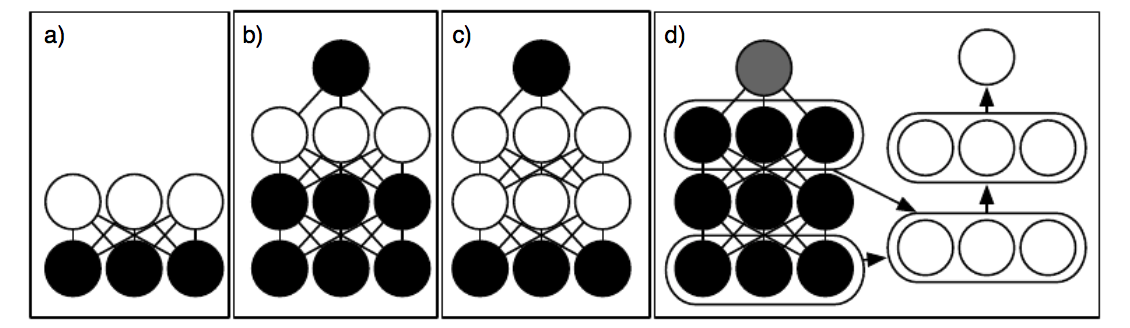

In [23]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "LWPT.png", width=700, height=500)

## 20.10 オートエンコーダーの生成モデル的視点 (A Generative View of Autoencoders)

- オートエンコーダーにMCMCと同様の働きを持たせることができる。
- cf. 一般的なMCMCの働き
 1. 低確率の状態から高確率の状態に移動する
 2. ランダムネスを付加することで、状態空間上のあらゆる状態に遍く訪れることができる


### 20.10.1 デノイジングオートエンコーダーを用いたマルコフ連鎖 (Markov Chain Associated with any Denoising Auto-Encoder) 

"Generalized Denoising Autoencoders"によるマルコフ連鎖の生成(Bengio et al. (2013b))の手順は以下の通りである。


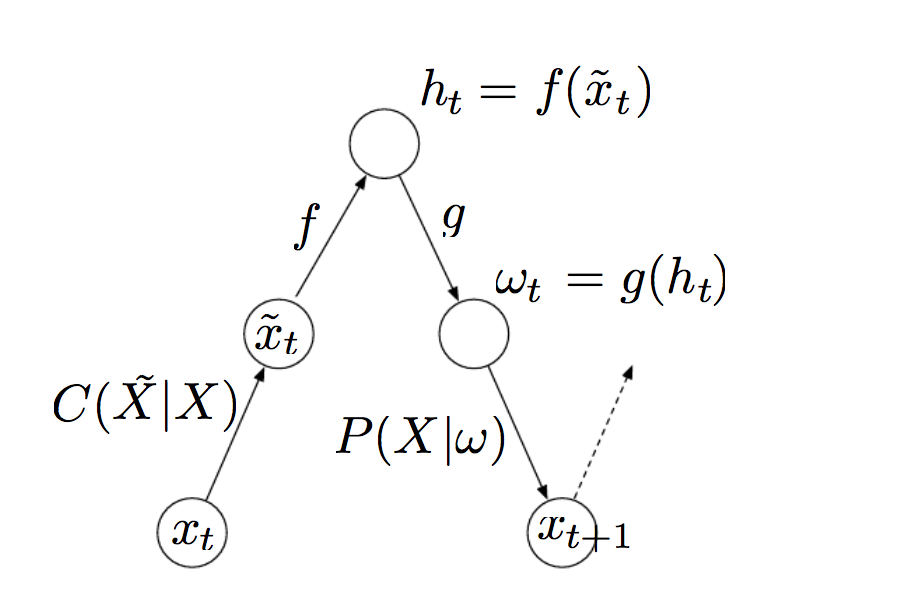

In [8]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "DAE.png", width=500, height=500)

- **手順**
 1. 状態$\bf{x}$に対し、ノイズを付加する。ノイズが付加された状態$\tilde{\bf{x}}$は、$C(\tilde{\bf{x}}|\bf{x})$からサンプリングされる
 2. $\bf{h}=f(\tilde{\bf{x}})$ とencodeする
 3. $\bf{\omega}=g(\bf{h})$ とdecodeする
 4. 次の状態を、$P(\bf{x}|\tilde{\bf{x}})$からサンプリングする


## 20.11 確率的生成ネットワーク (Generative Stochastic Network, 以下GSN)

- Denoising Autoencoder の一般化
- 隠れ変数を含んだマルコフ連鎖生成モデル

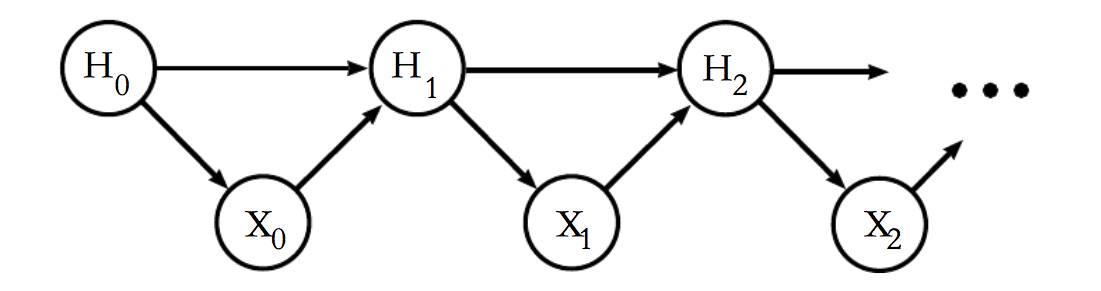

In [10]:
PATH = "/Users/takahirotsunoda/abc/images/"
Image(filename = PATH + "GSN.png", width=700, height=700)

- 手順
 1. 隠れ変数$H_k$が与えられたとき、可視変数$X_k$が$P(X_k|H_K)$によって与えられる
 2. 隠れ変数$H_{k-1}$と可視変数$X_{k-1}$が与えられたとき、可視変数$H_k$が$P(H_k|H_{k-1},X_{k-1})$によって与えられる


## 20.12 方法論に関するメモ (Methodological Notes)

生成モデルの研究を行うときには、以下の点に気をつけなければいけない。

1. どの統計量で比較するのか? (cf. 尤度,KL-divergence, ELBO,...etc.)
2. 用いている評価基準は信頼できるものなのか? 
3. データの前処理がいつも同じか? (例えば、MNISTデータをbinaryとしてインプットするかgray-scaleでインプットするかで良し悪しが変わる)
等 ...